In [12]:
# read three pkl files and combine them into one
import pickle
import pandas as pd
import os

## Postprocess annotation files

In [ ]:
# Folder containing the pickle files
folder_path = '/home/nele_pauline_suffo/ProcessedData/annotations_superannotate/'

# List to store individual DataFrames
dataframes = []

# Iterate over all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.pkl'):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'rb') as f:
            df = pickle.load(f)
            dataframes.append(df)

# Combine all DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)

# Store the combined DataFrame into a new pickle file
combined_df.to_pickle('/home/nele_pauline_suffo/ProcessedData/annotations_superannotate/quantex_share_annotations.pkl')


## Postprocess Prediction File

In [13]:
# Read the pickle file into a DataFrame
vtc_share_predictions = pd.read_pickle('/home/nele_pauline_suffo/outputs/vtc/quantex_share_vtc_output_20.pkl')

# Strip the audio_file_name by removing the '_16kHz' extension and everything afterwards
vtc_share_predictions['audio_file_name'] = vtc_share_predictions['audio_file_name'].str.split('_').str[0]

# Display the first few rows to verify the changes
vtc_share_predictions.head()

,audio_file_name,Utterance_Start,Utterance_Duration,Voice_type,Utterance_End
0,100898,0.231,29.541,SPEECH,29.772
1,100898,0.251,1.453,KCHI,1.704
2,100898,1.011,0.255,CHI,1.266
3,100898,1.851,1.774,FEM,3.625
4,100898,3.731,5.827,KCHI,9.558


In [14]:
# load df from pickle file^
annotations_output = pd.read_pickle('/home/nele_pauline_suffo/ProcessedData/annotations_superannotate/quantex_share_annotations.pkl')

In [15]:


example_annotation = annotations_output[annotations_output['audio_file_name'] == '672793']
example_prediction = vtc_share_predictions[vtc_share_predictions['audio_file_name'] == '672793']

(0.0, 60.0)

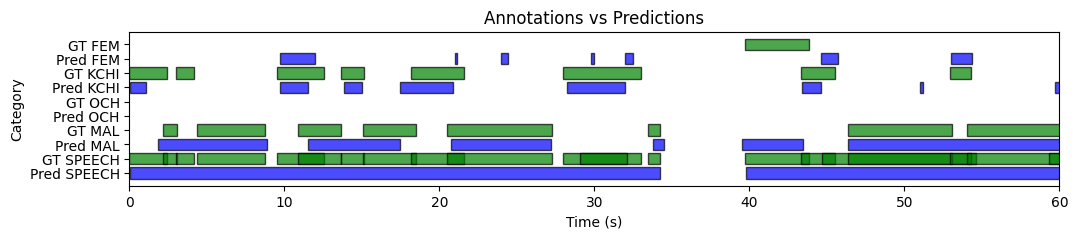

In [ ]:
import matplotlib.pyplot as plt

# Set up the figure and axis
plt.figure(figsize=(12, 2))
ax = plt.gca()

ground_truth_fem = example_annotation[example_annotation['Voice_type'] == 'FEM']
ground_truth_mal = example_annotation[example_annotation['Voice_type'] == 'MAL']
ground_truth_kchi = example_annotation[example_annotation['Voice_type'] == 'KCHI']
ground_truth_och = example_annotation[example_annotation['Voice_type'] == 'OCH']
ground_truth_speech = example_annotation[example_annotation['Voice_type'] == 'SPEECH']
predictions_fem = example_prediction[example_prediction['Voice_type'] == 'FEM']
predictions_mal = example_prediction[example_prediction['Voice_type'] == 'MAL']
predictions_kchi = example_prediction[example_prediction['Voice_type'] == 'KCHI']
predictions_och = example_prediction[example_prediction['Voice_type'] == 'OCH']
predictions_speech = example_prediction[example_prediction['Voice_type'] == 'SPEECH']

# Define y-positions for the two bars
y_ground_truth_kchi = 9
y_predictions_kchi = 8

y_ground_truth_fem = 7
y_predictions_fem = 6

y_ground_truth_och = 5
y_predictions_och = 4 

y_ground_truth_mal = 3
y_predictions_mal = 2

y_ground_truth_speech = 1
y_predictions_speech = 0

# Plot predictions, excluding SPEECH
for idx, row in predictions_fem.iterrows():
    ax.barh(y_predictions_fem, row['Utterance_Duration'], left=row['Utterance_Start'], color='blue', edgecolor='black', alpha=0.7)

for idx, row in predictions_mal.iterrows():
    ax.barh(y_predictions_mal, row['Utterance_Duration'], left=row['Utterance_Start'], color='blue', edgecolor='black', alpha=0.7)

for idx, row in predictions_kchi.iterrows():
    ax.barh(y_predictions_kchi, row['Utterance_Duration'], left=row['Utterance_Start'], color='blue', edgecolor='black', alpha=0.7)

for idx, row in predictions_och.iterrows():
    ax.barh(y_predictions_och, row['Utterance_Duration'], left=row['Utterance_Start'], color='blue', edgecolor='black', alpha=0.7)

for idx, row in predictions_speech.iterrows():
    ax.barh(y_predictions_speech, row['Utterance_Duration'], left=row['Utterance_Start'], color='blue', edgecolor='black', alpha=0.7)
    
for idx, row in ground_truth_fem.iterrows():
    ax.barh(y_ground_truth_fem, row['Utterance_Duration'], left=row['Utterance_Start'], color='green', edgecolor='black', alpha=0.7)
    
for idx, row in ground_truth_mal.iterrows():
    ax.barh(y_ground_truth_mal, row['Utterance_Duration'], left=row['Utterance_Start'], color='green', edgecolor='black', alpha=0.7)

for idx, row in ground_truth_kchi.iterrows():
    ax.barh(y_ground_truth_kchi, row['Utterance_Duration'], left=row['Utterance_Start'], color='green', edgecolor='black', alpha=0.7)
    
for idx, row in ground_truth_och.iterrows():
    ax.barh(y_ground_truth_och, row['Utterance_Duration'], left=row['Utterance_Start'], color='green', edgecolor='black', alpha=0.7)
    
for idx, row in ground_truth_speech.iterrows():
    ax.barh(y_ground_truth_speech, row['Utterance_Duration'], left=row['Utterance_Start'], color='green', edgecolor='black', alpha=0.7)
    
    

# Adjust y-axis ticks and labels
ax.set_yticks([y_ground_truth_speech, y_predictions_speech, y_ground_truth_fem, y_predictions_fem, y_ground_truth_mal, y_predictions_mal, y_ground_truth_kchi, y_predictions_kchi, y_ground_truth_och, y_predictions_och])
ax.set_yticklabels(["GT SPEECH", "Pred SPEECH", "GT FEM", "Pred FEM", "GT MAL", "Pred MAL", "GT KCHI", "Pred KCHI", "GT OCH", "Pred OCH"])

# Add labels and titles
ax.set_xlabel("Time (s)")
ax.set_ylabel("Category")
ax.set_title("Annotations vs Predictions")
ax.set_xlim(0, 60)

## Compute Evaluation Metrics

In [17]:
# Get the list of audio files that have annotations
annotated_files = annotations_output['audio_file_name'].unique()

# Filter the hypothesis DataFrame to only include these files
predictions = vtc_share_predictions[vtc_share_predictions['audio_file_name'].isin(annotated_files)]

In [18]:
from pyannote.core import Annotation, Segment
def dataframe_to_annotation(df, label_column="Voice_type"):
    """
    Converts a DataFrame to a pyannote.core.Annotation object.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with 'Utterance_Start', 'Utterance_End', and a label column.
    - label_column (str): Column name for the labels (default: 'Voice_type').

    Returns:
    - Annotation: pyannote.core.Annotation object.
    """
    annotation = Annotation()
    for _, row in df.iterrows():
        start = float(row["Utterance_Start"])
        end = float(row["Utterance_End"])
        label = row[label_column]
        annotation[Segment(start, end)] = label
    return annotation

In [21]:
pip install pyannote.metrics

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 157.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 146.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 101.4 MB/s eta 0:00:00
  Attempting uninstall: pyannote.core
    Found existing installation: pyannote.core 3.7.1
    Uninstalling pyannote.core-3.7.1:
      Successfully uninstalled pyannote.core-3.7.1
  Attempting uninstall: pyannote.database
    Found existing installation: pyannote.database 3.0.1
    Uninstalling pyannote.database-3.0.1:
      Successfully uninstalled pyannote.database-3.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following 

In [20]:
import pandas as pd
from pyannote.metrics.detection import DetectionPrecisionRecallFMeasure, DetectionErrorRate
from pyannote.core import Annotation, Segment

def dataframe_to_annotation(df, label_column="Voice_type"):
    """
    Converts a DataFrame to a pyannote.core.Annotation object.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with 'Utterance_Start', 'Utterance_End', and a label column.
    - label_column (str): Column name for the labels (default: 'Voice_type').

    Returns:
    - Annotation: pyannote.core.Annotation object.
    """
    annotation = Annotation()
    for _, row in df.iterrows():
        start = float(row["Utterance_Start"])
        end = float(row["Utterance_End"])
        label = row[label_column]
        annotation[Segment(start, end)] = label
    return annotation

# Load reference and hypothesis DataFrames
reference_df = pd.read_pickle('/home/nele_pauline_suffo/ProcessedData/annotations_superannotate/quantex_share_annotations.pkl')
hypothesis_df = pd.read_pickle('/home/nele_pauline_suffo/outputs/vtc/quantex_share_vtc_output_20.pkl')

# Get the list of unique audio files (videos)
all_videos = reference_df['audio_file_name'].unique()
voice_types = ['KCHI', 'OCH', 'FEM', 'MAL', 'SPEECH']  # Ensure lowercase
class_metrics = {voice_type: {'precision': [], 'recall': [], 'f1_score': [], 'error_rate': []} for voice_type in voice_types}

# Loop over each video
for video in all_videos:
    # Filter DataFrames for the current video
    reference_filtered = reference_df[reference_df['audio_file_name'] == video]
    hypothesis_filtered = hypothesis_df[hypothesis_df['audio_file_name'] == video]

    # Skip if there are no annotations for this video
    if reference_filtered.empty:
        print(f"No annotations available for video: {video}. Skipping.")
        continue

    # Convert to pyannote Annotations
    reference_annotation = dataframe_to_annotation(reference_filtered)
    hypothesis_annotation = dataframe_to_annotation(hypothesis_filtered)

    # Initialize metrics
    detection_f1 = DetectionPrecisionRecallFMeasure(collar=0, skip_overlap=False)
    detection_error_rate = DetectionErrorRate(collar=0, skip_overlap=False)

    # Compute the detection metrics
    detection_f1(reference_annotation, hypothesis_annotation)
    error_rate = detection_error_rate(reference_annotation, hypothesis_annotation)

    # Retrieve precision, recall, and F1 score
    precision, recall, f1_score = detection_f1.compute_metrics()

    # Now, compute metrics per class within this video
    for voice_type in voice_types:
        # Filter annotations for the current voice type
        ref_class_filtered = reference_filtered[reference_filtered['Voice_type'] == voice_type]
        hyp_class_filtered = hypothesis_filtered[hypothesis_filtered['Voice_type'] == voice_type]

        # Skip if there are no annotations for this class in reference
        # if ref_class_filtered.empty:
        #     print(f"No annotations for class '{voice_type}' in video '{video}'. Skipping.")
        #     continue

        # Convert to pyannote Annotations
        reference_class_annotation = dataframe_to_annotation(ref_class_filtered)
        hypothesis_class_annotation = dataframe_to_annotation(hyp_class_filtered)

        # Initialize class-specific metrics
        detection_f1_class = DetectionPrecisionRecallFMeasure(collar=0, skip_overlap=False)
        error_rate_metric_class = DetectionErrorRate(collar=0, skip_overlap=False)

        # Compute the detection metrics for this class
        detection_f1_class(reference_class_annotation, hypothesis_class_annotation)
        error_rate_class = error_rate_metric_class(reference_class_annotation, hypothesis_class_annotation)

        # Retrieve precision, recall, and F1 score
        precision_class, recall_class, f1_score_class = detection_f1_class.compute_metrics()

        # Store the per-class results
        class_metrics[voice_type]['precision'].append(precision_class)
        class_metrics[voice_type]['recall'].append(recall_class)
        class_metrics[voice_type]['f1_score'].append(f1_score_class)
        class_metrics[voice_type]['error_rate'].append(error_rate_class)

print("\nAveraged Metrics Per Class Over All Videos:")
avg_f1_scores_per_class = []  # List to store avg F1 scores per class

for voice_type in voice_types:
    precisions = class_metrics[voice_type]['precision']
    recalls = class_metrics[voice_type]['recall']
    f1_scores = class_metrics[voice_type]['f1_score']
    error_rates = class_metrics[voice_type]['error_rate']

    if precisions:
        avg_precision = sum(precisions) / len(precisions)
        avg_recall = sum(recalls) / len(recalls)
        avg_f1 = sum(f1_scores) / len(f1_scores)
        avg_error_rate = sum(error_rates) / len(error_rates)
    else:
        avg_precision = avg_recall = avg_f1 = avg_error_rate = 0

    avg_f1_scores_per_class.append(avg_f1)

    print(f"Class '{voice_type.upper()}':")
    print(f"  Precision: {avg_precision:.3f}")
    print(f"  Recall: {avg_recall:.3f}")
    print(f"  F1 Score: {avg_f1:.3f}")
    print(f"  Error Rate: {avg_error_rate:.3f}\n")
    
# Calculate the final F1 score over all classes
if avg_f1_scores_per_class:
    final_f1_score = sum(avg_f1_scores_per_class) / len(avg_f1_scores_per_class)
else:
    final_f1_score = 0

print(f"Final F1 Score over all classes: {final_f1_score:.3f}")

ModuleNotFoundError: No module named 'pyannote.metrics'